In [1]:
# import packages
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchkbnufft as tkbn
import utils.dsp
import utils.phantom
import utils.opt
from recon.TV_FISTA import tvdeblur

# get device
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

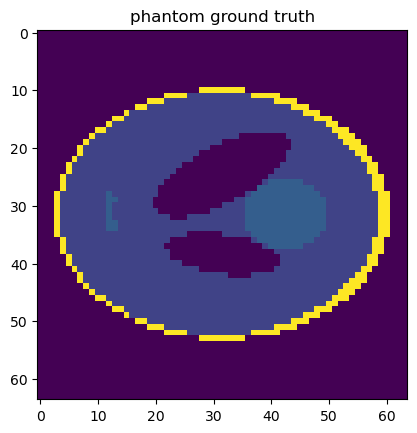

/var/folders/0g/9yswjs9x53vgk112mrdn05mm0000gn/T/ipykernel_66343/3737154058.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p = torch.tensor(p).to(device)


In [2]:
# generate phantom
N = 64
p = utils.phantom.phantom3d((N,N,1)).squeeze().to(device)
plt.figure(0)
plt.imshow(np.absolute(p.cpu().numpy()))
plt.title('phantom ground truth')
plt.show()

p = torch.tensor(p).to(device)

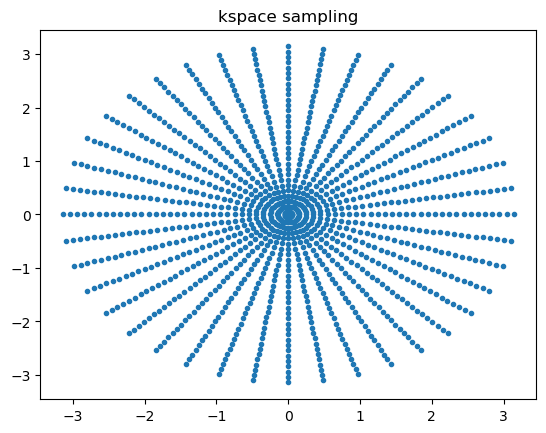

In [3]:
# generate kspace trajectory
kspoke = np.stack((np.linspace(-np.pi,np.pi,N),np.zeros((N))),axis=0)
nspokes = 20

for i in range(0,nspokes):
    theta = np.pi*i/nspokes
    R = [[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]]
    kspokei = np.matmul(R,kspoke)
    if i == 0:
        klocs = kspokei
    else:
        klocs = np.concatenate((klocs,kspokei),axis=1)

plt.figure(0)
plt.plot(klocs[0,:],klocs[1,:],'.')
plt.title('kspace sampling')
plt.show()

klocs = torch.tensor(klocs).to(device)

In [4]:
# create the nufft object and define fwd/adj operators
nufft_ob = tkbn.KbNufft(im_size=(N,N))
adjnufft_ob = tkbn.KbNufftAdjoint(im_size=(N,N))

smaps = utils.phantom.simsmaps((N,N,1)).squeeze().to(device)

def A_fwd(x):
    x = x.clone().unsqueeze(0).unsqueeze(0)
    return nufft_ob(x,klocs,smaps=smaps.unsqueeze(0))
def A_adj(b):
    return adjnufft_ob(b,klocs,smaps=smaps.unsqueeze(0)).clone().squeeze()

/Users/djfrey/code/tvrec/utils/phantom.py:97: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_52h9q6gsr9/croot/pytorch-select_1707258249748/work/torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(smaps,dtype=torch.complex128)


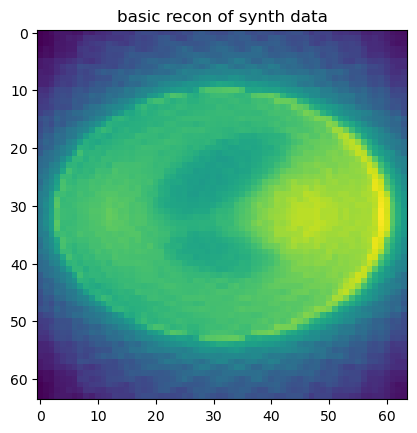

In [5]:
# synthesize kspace data and show basic recon
kdata = A_fwd(p)

plt.figure(0)
plt.imshow(np.absolute(A_adj(kdata).cpu().numpy()))
plt.title('basic recon of synth data')
plt.show()

In [6]:
# estimate the Lipschitz constant using power iteration
L = utils.opt.pwritr(A_fwd,A_adj,p)
print(L)

tensor(12608.7907, dtype=torch.float64)


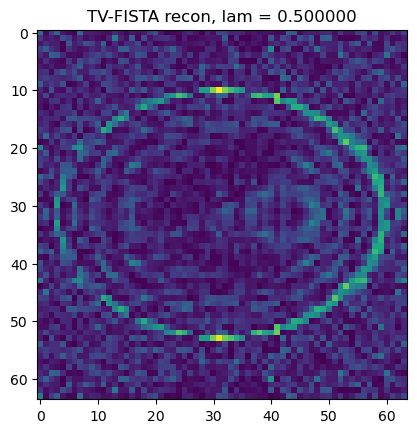

In [32]:
# recon the image
lam = 0.5
niter = 100
x_star, cost, x_set = tvdeblur(A_fwd, A_adj, kdata, lam=lam, niter=niter, L=L, chat=0)

plt.figure(0)
plt.imshow(np.absolute(x_star.cpu().numpy()))
plt.title('TV-FISTA recon, lam = %f' % lam)
plt.show()

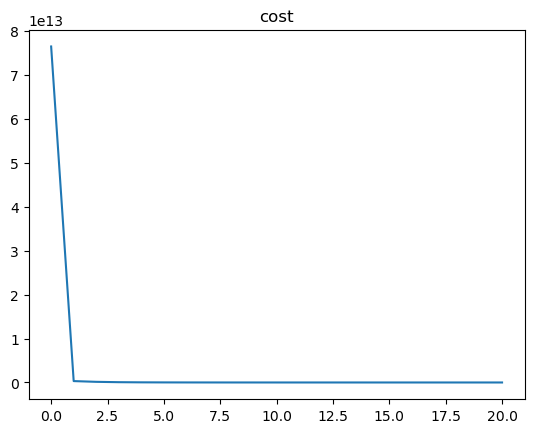

tensor(68145481.2692, dtype=torch.float64)


In [29]:
# analyze if you want to
plt.figure(0)
plt.plot(cost)
plt.title('cost')
plt.show()

print(cost[20])